## Set Up and Load Data

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 15)

In [156]:
df = pd.read_csv('dataset/train.csv', index_col='PassengerId')
df.drop(['Name'], axis=1, inplace=True)

## EDA

In [157]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(5)
memory usage: 823.5+ KB


In [159]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0].index

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
      dtype='object')

In [160]:
missing_values

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [161]:
columns_with_missing = missing_values[missing_values > 0].index.tolist()
columns_with_missing

['HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']

In [162]:
object_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(exclude='object').columns.tolist()

In [163]:
for col in object_cols:
    print(f'{col}: {df[col].unique()}')

HomePlanet: ['Europa' 'Earth' 'Mars' nan]
CryoSleep: [False True nan]
Cabin: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
VIP: [False True nan]


In [164]:
df['Side'] = df['Cabin'].str.split('/').str[-1]

In [165]:
home_transported = df[['HomePlanet','Transported']].copy()
home_transported['HomePlanet'].fillna('Missing', inplace=True)

/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_9620/2813928439.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  home_transported['HomePlanet'].fillna('Missing', inplace=True)


In [166]:
home_transported = pd.DataFrame(home_transported.groupby(['HomePlanet','Transported']).size()).reset_index()

In [167]:
home_transported.columns = ['HomePlanet','Transported','Count']

In [168]:
home_transported

,HomePlanet,Transported,Count
0,Earth,False,2651
1,Earth,True,1951
2,Europa,False,727
3,Europa,True,1404
4,Mars,False,839
5,Mars,True,920
6,Missing,False,98
7,Missing,True,103


In [169]:
for i in home_transported.HomePlanet.unique().tolist():
    for j in home_transported.Transported.unique().tolist():
        count = home_transported[(home_transported['HomePlanet'] == i) & (home_transported['Transported'] == j)]['Count']
        home_transported.loc[(home_transported['HomePlanet'] == i) & (home_transported['Transported'] == j), 'percentage'] = round(count/(home_transported.groupby('HomePlanet')['Count'].sum()[i])*100,2)

In [170]:
home_transported.set_index(['HomePlanet'], inplace=True)

In [171]:
home_transported_pivot = home_transported.pivot(columns='Transported', values='percentage')
home_transported_pivot

Transported,False,True
HomePlanet,,
Earth,57.61,42.39
Europa,34.12,65.88
Mars,47.70,52.30
Missing,48.76,51.24


1. Data Structure for Stacked Bars
In a stacked bar chart, you need a DataFrame where:
- The index represents the categories for the bars (e.g., HomePlanet).
- The columns represent the different segments of the bars (e.g., Transported status).
- The values in the DataFrame represent the heights of these segments.

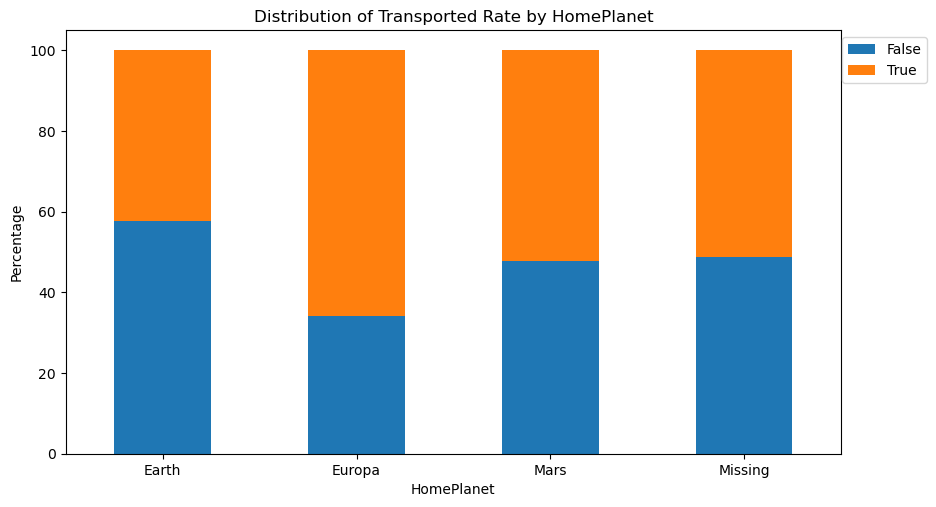

In [176]:
home_transported_pivot.plot(kind='bar', stacked=True, figsize=(10, 5.5), rot=0, legend=True, ylabel='Percentage', title='Distribution of Transported Rate by HomePlanet')
plt.legend(loc='upper right', bbox_to_anchor=(1.12, 1))

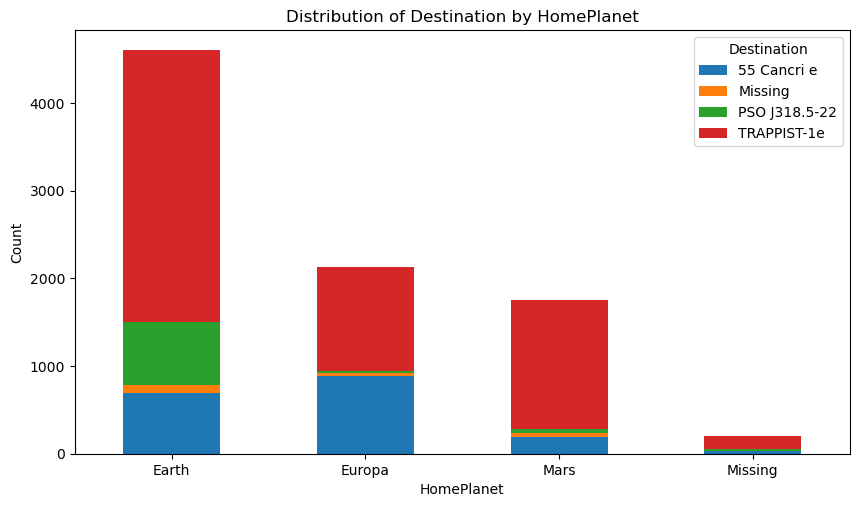

In [257]:
def homeplanet_other(dataframe, column_name):
    sample_df = dataframe[['HomePlanet',column_name]].copy().reset_index().drop('PassengerId', axis=1)
    sample_df.fillna('Missing', inplace=True) 
    sample_df = pd.DataFrame(sample_df.groupby(['HomePlanet'])[column_name].value_counts())
    sample_df_pivot = sample_df.pivot_table(index='HomePlanet', columns=column_name, values='count', aggfunc='sum', fill_value=0)
    plot = sample_df_pivot.plot(kind='bar', stacked=True, figsize=(10, 5.5), rot=0, legend=True, ylabel='Count', title=f'Distribution of {column_name} by HomePlanet')
    return sample_df, plot, sample_df_pivot
home_dest, plot, data_pivot = homeplanet_other(df, 'Destination')